# Approximating Steel Cased Wells - DC

[Lindsey Heagy](http://github.com/lheagy)

This notebook was used to produce Figure 3 in Heagy and Oldenburg, 2018. 

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches
from matplotlib import gridspec
import ipywidgets
from string import ascii_lowercase

import discretize
from discretize import utils
from SimPEG import Utils, Maps
from SimPEG.Survey import Data
from pymatsolver import Pardiso


import casingSimulations as casingSim

%matplotlib inline

##  Parameters

To examine the impact of replacing the steel cased well with a solid well, I have run a few simulations using SimPEG and simulating the DC resistivity equations using a finite volume approach on a 3D cylindrical mesh.  

In [2]:
simDir = 'Flawed_DC_small'  # create a simulation directory where results can be saved. 

In [3]:
casing_l = 50
sigma_back = 1e-1
casing_d = 10e-2 #10cm diameter
casing_t = 1e-2 #1cm thickness

print(
    'The casing is {}m long, and the '
    'conductivity of the background is {} S/m'.format(
        casing_l, sigma_back
    )
)

The casing is 50m long, and the conductivity of the background is 0.1 S/m


In [4]:
model = casingSim.model.FlawedCasingInHalfspace(
    directory=simDir,
    sigma_casing= 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 1e-4,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 10cm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    src_a = np.r_[0., 3*np.pi/2., -0.00125],  # put the A electrode just below the surface
    src_b = np.r_[1*casing_l, 3*np.pi/2., -0.00125] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, 3*np.pi/2., -0.00125]  

In [5]:
# Here we print the parameters being used to set up the simulation
model.serialize()

{'__class__': 'FlawedCasingInHalfspace',
 'casing_d': 0.09000000000000001,
 'casing_l': 50.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': 'Flawed_DC_small',
 'filename': 'ModelParameters.json',
 'flaw_r': [0.0, 0.0],
 'flaw_theta': [0.0, 6.283185307179586],
 'flaw_z': [0.0, 0.0],
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'mur_flaw': 1.0,
 'sigma_air': 0.0001,
 'sigma_back': 0.1,
 'sigma_casing': 5000000.0,
 'sigma_flaw': 5500000.0,
 'sigma_inside': 0.1,
 'src_a': [0.045000000000000005, 4.71238898038469, -0.00125],
 'src_b': [50.0, 4.71238898038469, -0.00125],
 'surface_z': 0.0,
 'version': '0.0.6'}

In [6]:
copiedmodelparams = {
    key: val for key, val in model.serialize().items() if key in dir(casingSim.model.CasingInHalfspace) and not key.startswith('_') 
}

In [7]:
background = casingSim.model.CasingInHalfspace(
    **copiedmodelparams
)

### Set up the models

In [8]:
flaw_depth = casing_l/2.
flaw_dz = [0.5, 0.05, 0.005]

In [9]:
flawed_models = {}

model.flaw_r = np.r_[model.casing_a, model.casing_b]
model.sigma_flaw = model.sigma_back

for dz in flaw_dz: 
    tmp_model = model.copy()
    tmp_model.flaw_z = np.r_[-dz, 0] - flaw_depth
    
    flawed_models["flaw_{}".format(dz)] = tmp_model

In [10]:
short_casing = model.copy()
short_casing.flaw_z = np.r_[-casing_l, -flaw_depth]
# partial_flaw = model.copy()

flawed_models['short'] = short_casing

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [11]:
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.ones(6)
# hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

In [12]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 10.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = .0025  # cell size in the z-direction 
domainx2 = 50  # go out 500m from the well

# padding parameters
npadx, npadz = 2, 14  # number of padding cells
pfx2 = 2  # expansion factor for the padding to infinity in the x-direction
pfz = 2

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
#     hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

1202280


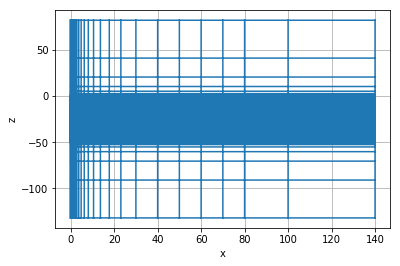

In [13]:
cylMeshGen.mesh.plotGrid()
print(cylMeshGen.mesh.nC)

In [14]:
src_theta = cylMeshGen.hy[0]/2. + np.pi
model.src_a[1] = src_theta
model.src_b[1] = src_theta

In [15]:
# Plot the source location

# ax = plt.subplot(111, projection='polar')
# cylMeshGen.mesh.plotGrid(ax=ax, slice='z')
# ax.plot(model.src_a[1], model.src_a[0], 'ro')
# ax.plot(model.src_b[1], model.src_b[0], 'rs')
# ax.set_ylim([0., 3*model.casing_l])

In [16]:
# put the models in a dictionary for convienence 
model_names = ['baseline'] + list(flawed_models.keys())
modelDict = {'baseline': background}
modelDict.update(flawed_models)

In [17]:
for mod in modelDict.values():
    mod.src_a[1] = src_theta
    mod.src_b[1] = src_theta

In [18]:
# Assign physical properties on the mesh
physpropsDict = dict(
    [
        (name, casingSim.model.PhysicalProperties(cylMeshGen, mod)) 
        for name, mod in modelDict.items()
    ]
)

In [19]:
modelDict

{'baseline': <casingSimulations.model.CasingInHalfspace at 0x1063e9208>,
 'flaw_0.005': <casingSimulations.model.FlawedCasingInHalfspace at 0xd15b218d0>,
 'flaw_0.05': <casingSimulations.model.FlawedCasingInHalfspace at 0xd15b219b0>,
 'flaw_0.5': <casingSimulations.model.FlawedCasingInHalfspace at 0xd15b219e8>,
 'short': <casingSimulations.model.FlawedCasingInHalfspace at 0xd15b21278>}

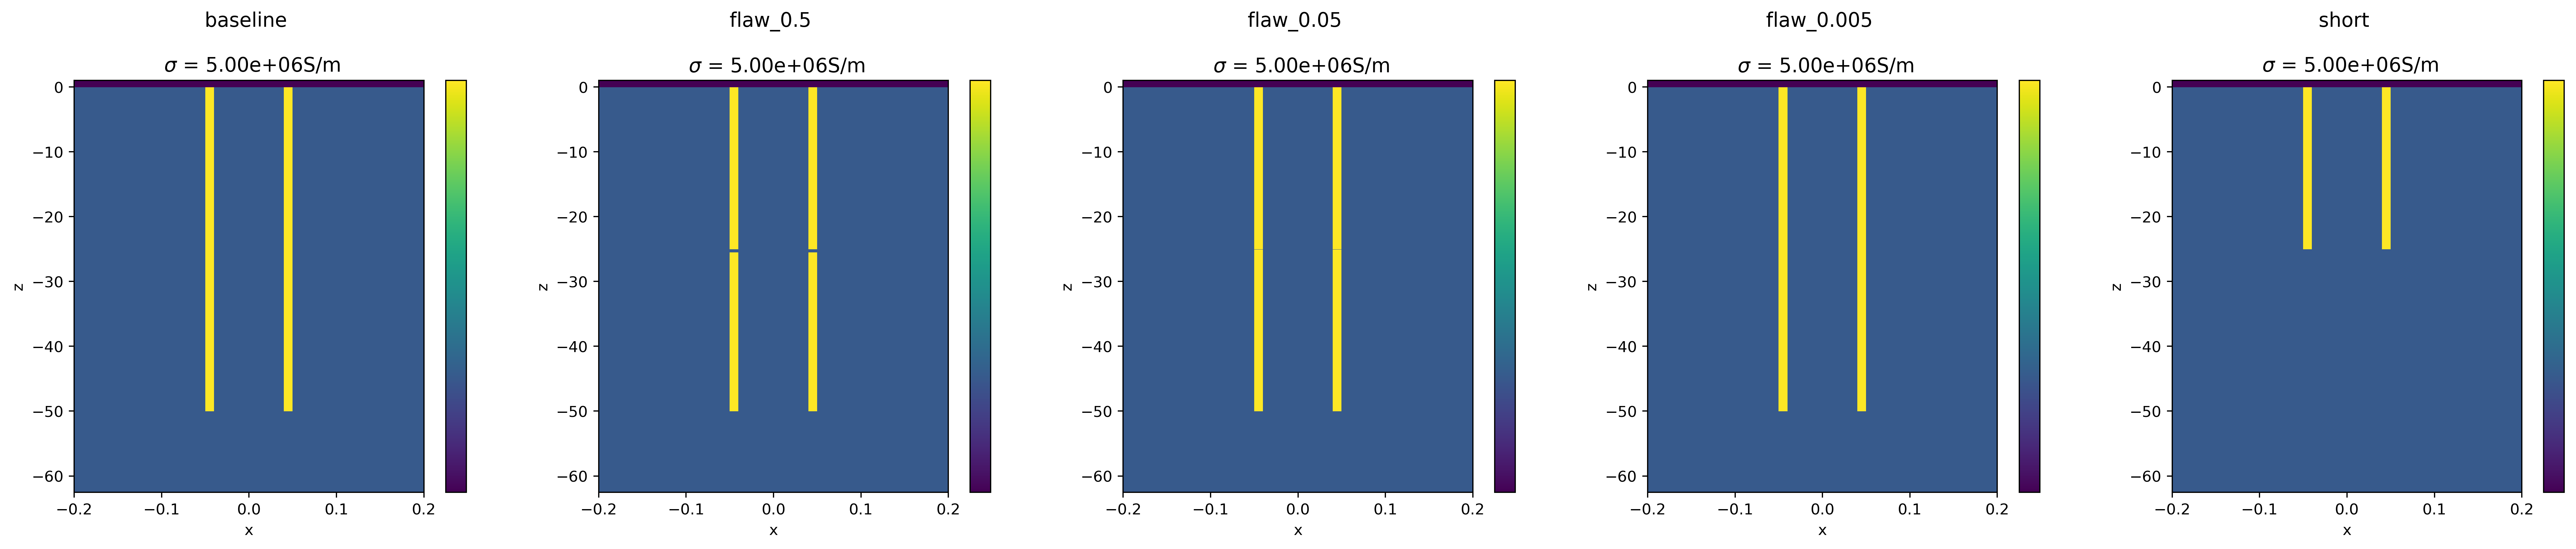

In [20]:
# Plot the models
xlim = 0.2*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-casing_l*1.25, 1]
    

theta_ind = 0

plot_models = model_names

fig, ax = plt.subplots(1, len(plot_models), figsize=(6*len(plot_models), 5), dpi=350)
for a, title in zip(ax, plot_models):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        theta_ind=theta_ind,
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
    a.set_xlim(xlim)
    a.set_ylim(zlim)

In [21]:
model.src_a, model.src_b

(array([ 4.50000000e-02,  6.28318531e+00, -1.25000000e-03]),
 array([ 5.00000000e+01,  6.28318531e+00, -1.25000000e-03]))

In [22]:
# Set up 4 sources, top casing, top & not coupled, downhole, downhole not coupled

# src_locs = [25, 50, 75, 100, 250, 500, 750, 1000., 2000.]
src_locs = [50.]

src_b = np.vstack(
    [[loc, model.src_b[1], model.src_b[2]] for loc in src_locs]
)

src_a = np.ones((src_b.shape[0], 1)) * model.src_a

In [23]:
src_b

array([[ 5.00000000e+01,  6.28318531e+00, -1.25000000e-03]])

## set up a DC simulation

In [24]:
# model_names = ["baseline", "flawed"]

In [25]:
simDict = {}
for key in model_names:
    simDict[key] = casingSim.run.SimulationDC(
        modelParameters=modelDict[key], directory=simDir, 
        meshGenerator=cylMeshGen, src_a=src_a, src_b=src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [26]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run(save=False)
    print('\n')

--- Running baseline ---
Validating parameters...
      max x: 140.0, min z: -131.92749999999998, max z: 81.9274999999545, nC: 1202280
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 8.368868827819824


--- Running flaw_0.5 ---
Validating parameters...
      max x: 140.0, min z: -131.92749999999998, max z: 81.9274999999545, nC: 1202280
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 6.19685697555542


--- Running flaw_0.05 ---
Validating parameters...
      max x: 140.0, min z: -131.92749999999998, max z: 81.9274999999545, nC: 1202280
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 6.556306838989258


--- Running flaw_0.005 ---
Validating parameters...
      max x: 140.0, min z: -131.92749999999998, max z: 81.9274999999545, nC: 1202280
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time 

## Plot Results


### View Fields, Fluxes, and Charges
This is a widget for interrogating the results.

- `max_r`: maximum radial extent of the plot (m)
- `min_depth`: minimum depth (m)
- `max_depth`: maximum depth (m)
- `clim_min`: minimum colorbar limit. If 0, then the colorbar limits are the plotting defaults
- `clim_max`: maximum colorbar limit. If 0, then the colorbar limits are the plotting defaults
- `model_key`: model which we are viewing
- `view`: field or physical property that is plotted
- `prim_sec`: primary plots the baseline (intact well), secondary subtracts the primary response from the current value (note that if you select baseline and secondary the value will be zero and an error thrown)
- `show_mesh`: if checked, the mesh will be plotted on the right hand half of the plot
- `casing_outline`: draws the outline of the casing

In [31]:
viewer = casingSim.FieldsViewer(
    sim_dict=simDict, fields_dict=fieldsDict, primary_key='baseline', model_keys=model_names
)

In [32]:
viewer.widget_cross_section(defaults={"min_depth":0, "max_depth":casing_l*1.25})

interactive(children=(FloatText(value=0.1, description='max_r'), FloatText(value=0.0, description='min_depth'), FloatText(value=62.5, description='max_depth'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('baseline', 'flaw_0.5', 'flaw_0.05', 'flaw_0.005', 'short', 'all'), value='baseline'), ToggleButtons(description='view', options=('sigma', 'e', 'j', 'phi', 'charge', 'charge_density'), value='sigma'), ToggleButtons(description='prim_sec', options=('total', 'primary', 'secondary', 'percent'), value='total'), Checkbox(value=False, description='show_mesh'), Checkbox(value=False, description='use_aspect'), Checkbox(value=True, description='casing_outline'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

### Plot Charges

In [34]:
mesh = cylMeshGen.mesh

In [35]:
def plot_charge(
    ax=None, key=model_names[0], color_ind=0, color=None, src_ind=0, 
    label=None, secondary=False, linestyle='-', primary_key="baseline"
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5, 4)) #, dpi=400)
    
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]    
    plotme = f[src, 'charge']
    
    if secondary is True:
        f_prim = fieldsDict[primary_key]
        src_prim = simDict[primary_key].survey.srcList[src_ind]
        plotme = plotme - f_prim[src_prim, 'charge']
    z_charges, charges = casingSim.casing_charges(plotme, mesh, mod)
    ax.plot(
        -z_charges, charges/csz, label=label, 
        color=color if color is not None else "C{}".format(color_ind), 
        linestyle=linestyle
    )
        

In [36]:
from matplotlib import rcParams
rcParams['font.size'] = 14

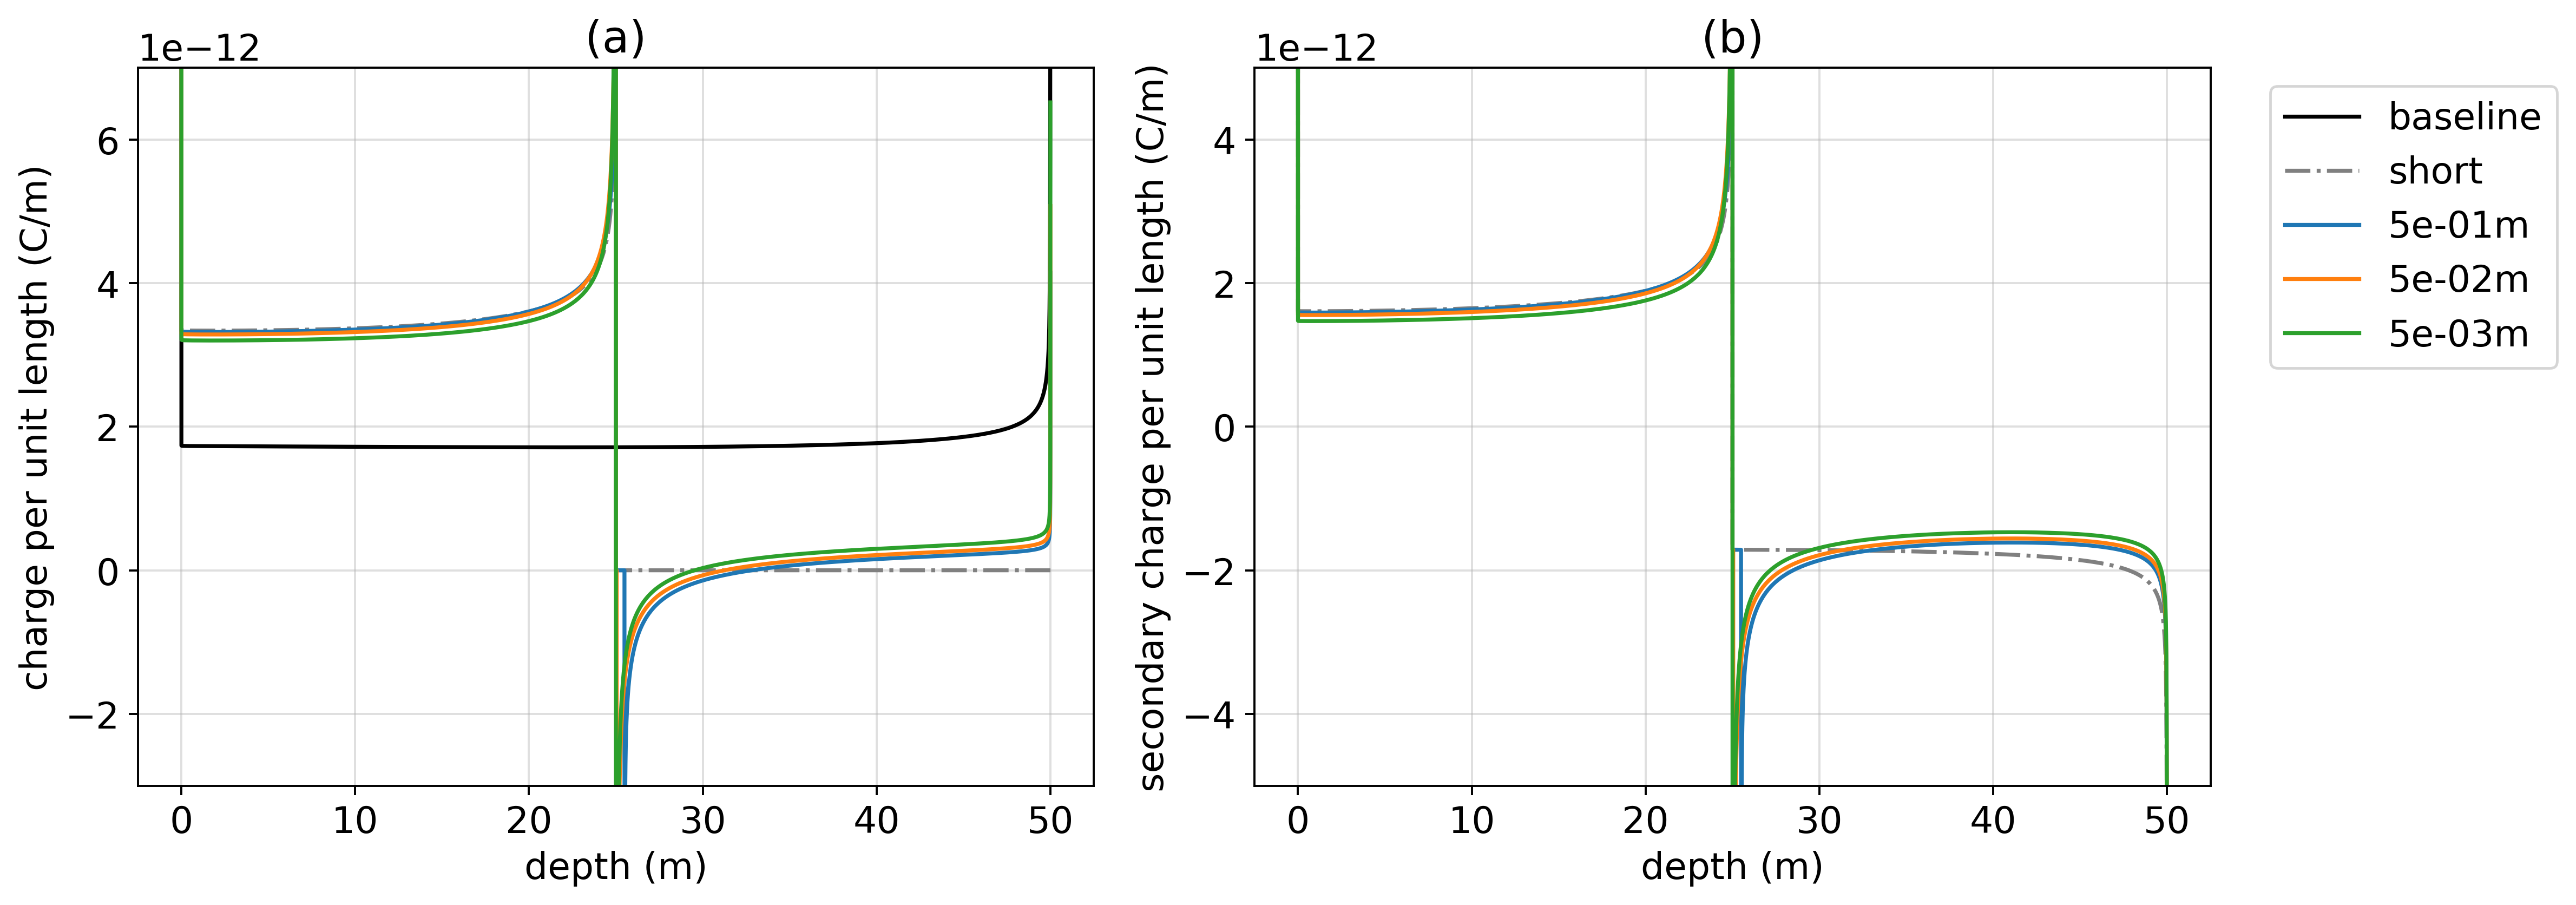

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi = 350)

primary_key = "baseline"
src_ind = 0
ylim = 8e-15*np.r_[-1, 1]

plot_models = ["baseline", "short"] + ["flaw_{}".format(dz) for dz in flaw_dz]

for i, key in enumerate(plot_models):
    
    label = key if key in ["baseline", "short"] else "{:1.0e}m".format(float(key.split("_")[-1]))
    
    plot_charge(
        ax=ax[0], key=key, color_ind=i-2 if key != primary_key else None, 
        color = "k" if key == primary_key else "0.5" if key == "short" else None,
        src_ind=src_ind, label=label, linestyle = '-.' if key == "short" else None 
    )
    if key != primary_key:
        plot_charge(
            ax=ax[1], key=key, color_ind=i-2 if key != primary_key else None, 
            color = "k" if key == primary_key else "0.5" if key == "short" else None,
            src_ind=src_ind, label=label, secondary=True, linestyle = '-.' if key == "short" else None
        )

for i, a in enumerate(ax):
#     a.legend()
    a.set_xlabel('depth (m)')
    a.set_ylabel('charge per unit length (C/m)' if i == 0 else 'secondary charge per unit length (C/m)')
    a.set_title("({})".format(ascii_lowercase[i]))
    a.grid(which='both', alpha=0.4)
    
ax[0].set_ylim([-3e-12, 7e-12])
ax[1].set_ylim(5e-12*np.r_[-1, 1])
#     a.set_xlim(1e-4, 20-1e-4)

ax[0].legend(bbox_to_anchor=[2.55, 1])

plt.tight_layout()
fig.savefig('../figures/casing_charge_flawdz', dpi=350, bbox_inches="tight")